In [12]:
# import the libraries
import torch,pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm

import matplotlib.pyplot as plt


In [13]:
# visualizatin function

def show(tensor, ch=1, size=(28,28), num=16):
    # tensor : 128(batch size) * 784(28*28)
    data = tensor.detach().cpu().view(-1,ch,*size) # view will reshape 128*1*28*28(-1 whatever remains after doing 1*28*28) # detach for removing gradients
    grid = make_grid(data[:num], nrow=4).permute(1,2,0) # (we are going to take 16 pictures)
    # use of permute because pytorch takes channel *w*h matplot takes as w*h*channel
    plt.imshow(grid)
    plt.show()

In [14]:
# setup of the main parameters and hyperparameters

epochs = 500
cur_step = 0
info_step = 300


mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64  # noise vector
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
#device = 'cuda'
device ='cpu'
dataloader = DataLoader(MNIST('.',download=True, transform=transforms.ToTensor()),shuffle = True,batch_size=bs)

# number of steps -> 60000/128 ~ 468



In [15]:
# declare our models

#Generator
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp,out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True))


class Generator(nn.Module):
    def __init__(self,z_dim=64,i_dim=784,h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim,h_dim), # 64,128
            genBlock(h_dim,h_dim*2), # 128,256
            genBlock(h_dim*2,h_dim*4), # 256 * 512
            genBlock(h_dim*4,h_dim*8), # 512 1024
            nn.Linear(h_dim*8, i_dim),
            nn.Sigmoid()
            )
        
    def forward(self,noise):
        return self.gen(noise)
    

def gen_noise(number, z_dim):
    return torch.randn(number,z_dim).to(device)


# Discriminator
def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp,out),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self,i_dim = 784, h_dim =256):
        super().__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim*4), # 784,1024
            discBlock(h_dim*4, h_dim*2),
            discBlock(h_dim*2, h_dim),
            nn.Linear(h_dim,1) # 251 1
     
        )

    def forward(self, image):
        return self.disc(image)



In [16]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)



In [17]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [18]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [20]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


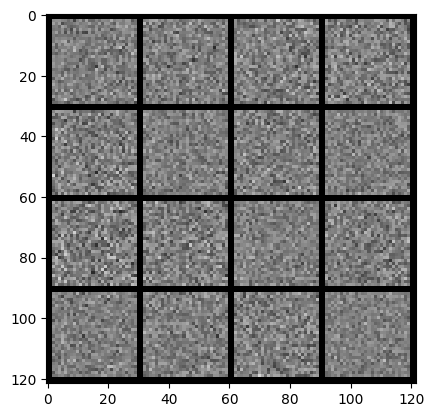

In [21]:
noise = gen_noise(bs,z_dim)
fake = gen(noise)
show(fake)

In [24]:
# Calculating the loss

# generator loss

def calc_gen_loss(loss_func,gen,disc,number,z_dim):
    noise = gen_noise(number,z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)

    gen_loss = loss_func(pred,targets)

    return gen_loss


def calc_disc_loss(loss_func,gen,disc,number,real,z_dim):
    noise = gen_noise(number,z_dim)
    fake = gen(noise)
    disc_fake = disc(fake.detach())  # do not want to optimize generator 

    disc_fake_target = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake,disc_fake_target)

    disc_real = disc(real)
    disc_real_taregets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real,disc_real_taregets)

    disc_loss = (disc_fake_loss +disc_real_loss)/2

    return disc_loss


 64%|██████▍   | 300/469 [00:49<00:32,  5.18it/s]

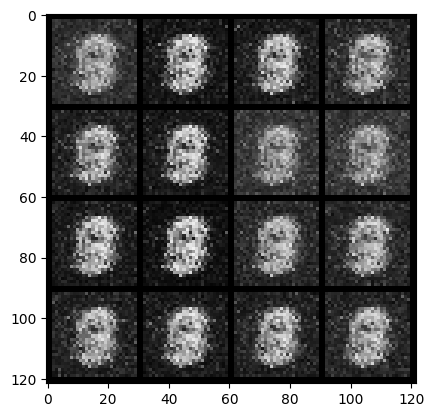

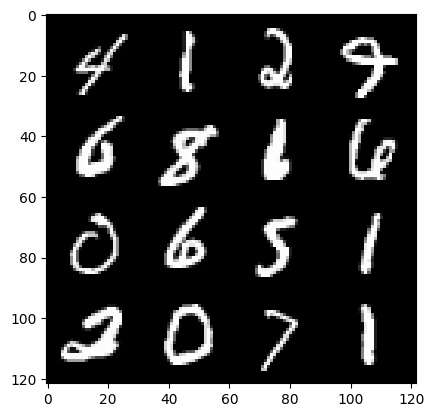

 64%|██████▍   | 301/469 [00:50<01:01,  2.72it/s]

0 : step 300 / Gen loss : 1.7574842061599096 / disc_loss ; 0.3546145728230474


 15%|█▍        | 70/469 [00:12<01:14,  5.39it/s]


KeyboardInterrupt: 

In [26]:
for epoch in range(epochs):
    for real, _ in tqdm(dataloader): # we dont need labels
        ### discriminator

        disc_opt.zero_grad()
        cur_bs = len(real) # 128 * 1 * 28*28
        real = real.view(cur_bs ,-1) # 128*784
        real = real.to(device)
        disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)

        disc_loss.backward(retain_graph=True)
        disc_opt.step()


        ### generator

        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()


        ### Visualization and stats

        mean_disc_loss += disc_loss.item()/info_step
        mean_gen_loss += gen_loss.item()/info_step

        if cur_step % info_step == 0  and cur_step > 0:
            fake_noise = gen_noise(cur_bs,z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real)

            print(f"{epoch} : step {cur_step} / Gen loss : {mean_gen_loss} / disc_loss ; {mean_disc_loss}")

            mean_gen_loss,mean_disc_loss = 0,0

        cur_step += 1
